# Segmenting one slice of a plusplus CT volume
We first import all needed packages.
You may need to change matplotlib backend, to see the animations. 

In [2]:
import skimage.io
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
import simple_snake_new as es
%matplotlib qt

## Explaining the basic principle of working with snake
Generating a figure which explains the basic principle of working with snake: a curve drawn in the image, which has an access to the pixel intensities. We will utilize pixel intensities to displace the curve in a normal direction. 

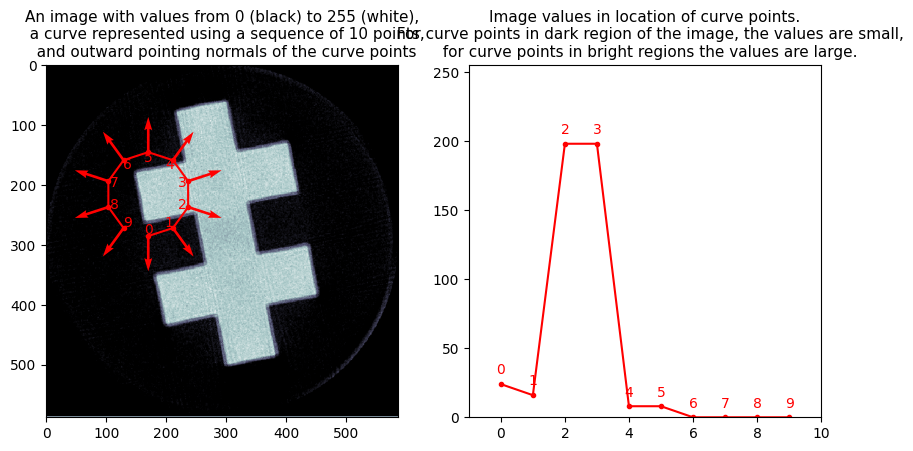

In [3]:
I = skimage.io.imread('../data/week6/plusplus.png')
I = I.mean(axis=2)  # Convert to grayscale

N = 10
radius = 70
center = np.array([215, 170])
snake = es.make_circular_snake(N, center, radius)
normals = es.get_normals(snake)

val = I[snake[:, 0].astype(int), snake[:, 1].astype(int)]  # NN interpolation

scale = 10
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(I, cmap='bone')
ax[0].plot(snake[:, 1], snake[:, 0], 'r.-')
ax[0].quiver(snake[:, 1], snake[:, 0], normals[:, 1], normals[:, 0], scale=scale, angles='xy', color='r')
ax[0].set_title(f'An image with values from 0 (black) to 255 (white),\n\
  a curve represented using a sequence of {N} points,\n\
  and outward pointing normals of the curve points', fontsize=11)

for p, xy in enumerate((snake - scale * normals)):
    ax[0].text(xy[1], xy[0], p, color='r', ha='center', va='center')

ax[1].plot(val, 'r.-')
for p, v in enumerate(val):
    ax[1].text(p, v + 10, p, color='r', ha='center', va='center')
ax[1].set_xlim(-1, N)
ax[1].set_ylim(0, 255)
ax[1].set_aspect((N+1) / 255)
ax[1].set_title('Image values in location of curve points.\n\
  For curve points in dark region of the image, the values are small,\n\
  for curve points in bright regions the values are large.', fontsize=11)
plt.show()

## Showing evolution
Iteratively (repetedly) displacing snake yields segmentation!

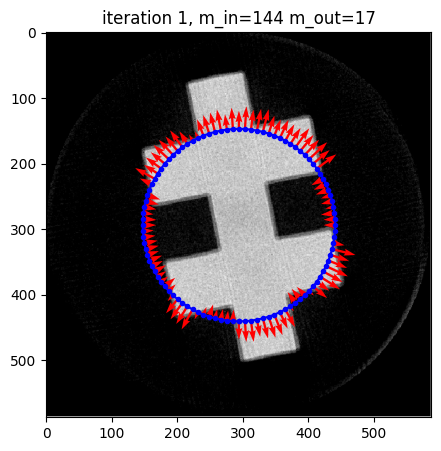

In [4]:
radius = min(I.shape)/4
center = np.array(I.shape)/2

N = 100

step_size = 0.0001
plot_pause = 0.01
alpha = 0.001
beta = 0.001

snake = es.make_circular_snake(N, center, radius)
B = es.regularization_matrix(N, alpha, beta)

fig, ax = plt.subplots(figsize=(5,5))

closed = np.hstack([np.arange(N), 0])  # Indices of the closed curve

total_time = 0

for i in range(100):
    
    mask = skimage.draw.polygon2mask(I.shape, snake)
    m_in = np.mean(I[mask])
    m_out = np.mean(I[~mask])
    
    normals = es.get_normals(snake)

    val = I[snake[:, 0].astype(int), snake[:, 1].astype(int)]  # NN interpolation
    f_ext = (m_in - m_out) * (2 * val -m_in - m_out)
    displacement = step_size * f_ext[:,None] * normals
    
    ax.clear()
    ax.imshow(I, cmap='gray')
    
    ax.plot(snake[closed, 1],snake[closed,0], 'b.-')
    ax.quiver(snake[:, 1], snake[:, 0], displacement[:, 1], displacement[:, 0],
              scale_units='xy', scale=0.1, angles='xy', color='r')
    ax.set_title(f'iteration {i+1}, m_in={int(m_in)} m_out={int(m_out)}')
    
    fig.canvas.draw()
    plt.pause(plot_pause)
  
    snake = snake + displacement
    snake = B @ snake
    snake = es.distribute_points(snake)
    snake = es.remove_intersections(snake)
    snake = es.keep_snake_inside(snake, I.shape)
      
plt.show()


## Showing the final result

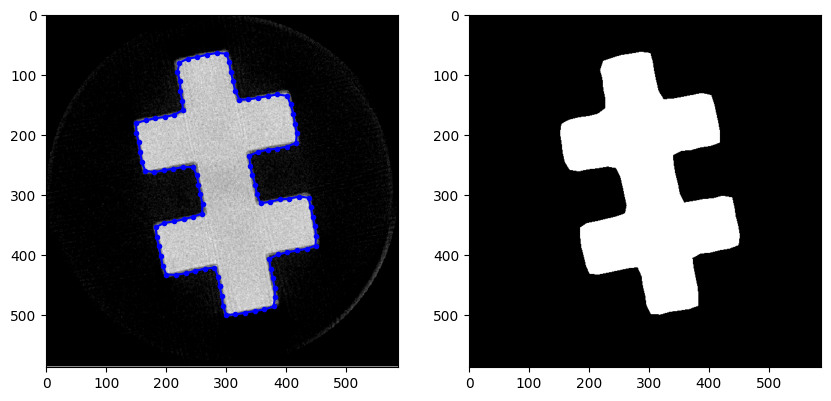

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(I, cmap='gray')
ax[0].plot(snake[closed, 1], snake[closed,0], 'b.-')
ax[1].imshow(mask,cmap='gray')
plt.show()